##**Data Loading & Filtering by Department 29**

In [5]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/project_dataset.csv')

# Display information
print("Dataset shape:", df.shape)
print("Columns:", df.columns)

Dataset shape: (10244, 8)
Columns: Index(['Date', 'IsHoliday', 'Dept', 'Weekly_Sales', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')


In [6]:
# Convert the date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

#department 29
data = df[df['Dept'] == 29]

# Sort by date
data = data.sort_values('Date')

# Set date as index
data = data.set_index('Date')

# Display first few rows
data.head()

,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,0,29.0,7024.95,42.31,2.572,211.096358,8.106
2010-02-12,1,29.0,7696.61,38.51,2.548,211.242170,8.106
2010-02-19,0,29.0,7966.55,39.93,2.514,211.289143,8.106
2010-02-26,0,29.0,4972.65,46.63,2.561,211.319643,8.106
2010-03-05,0,29.0,5306.70,46.50,2.625,211.350143,8.106




*   Date The week ending date for the sales — our time axis.
*   IsHoliday	1 if that week included a holiday (like Thanksgiving), otherwise 0. Can affect sales a lot.
*   Dept Always 29.0 — since we filtered only this department.
*   Weekly_Sales	The total sales for Department 29 in that store during the week. This is the target we want to forecast.
*   Temperature	Average temperature that week. May affect customer behavior.
*   Fuel_Price	Average fuel price — can reflect transportation costs and economic activity.
*   CPI	Consumer Price Index — a measure of inflation, affecting spending.
*   Unemployment	Unemployment rate — influences how much people are likely to spend.









##**Time Series Visualization & ACF/PACF Analysis**

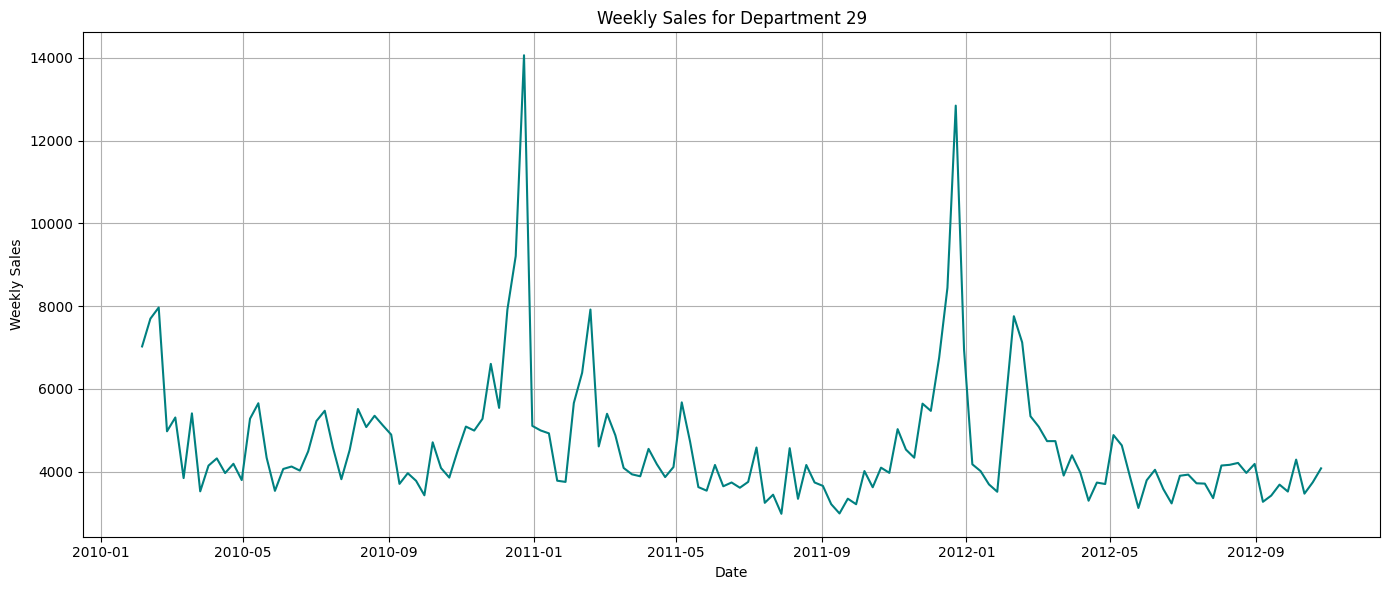

In [7]:
import matplotlib.pyplot as plt

# Plot weekly sales
plt.figure(figsize=(14,6))
plt.plot(data['Weekly_Sales'], color='teal')
plt.title('Weekly Sales for Department 29')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


The chart displays weekly sales for Department 29 from early 2010 to mid-2012. Key observations:

Sales fluctuate between approximately 2,000 and 6,000 for most of the period, with occasional spikes.
Two significant peaks occur: one around mid-2010 reaching ~8,000, and another around early 2012 nearing 12,000.
A sharp peak exceeds 14,000 in late 2010, followed by a rapid decline.
After early 2012, sales trend downward, stabilizing around 2,000-4,000 by mid-2012.

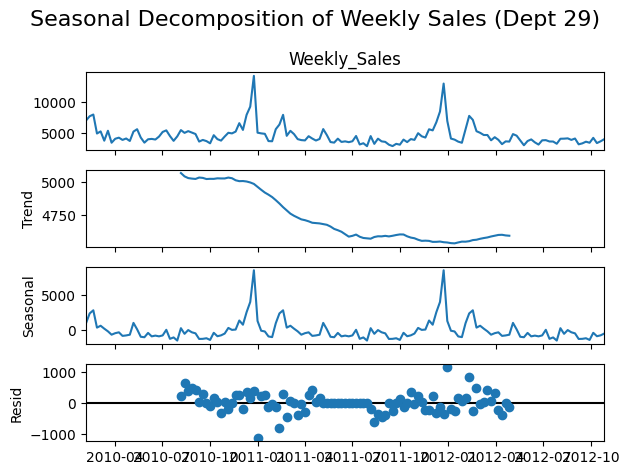

In [8]:
#Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the series
decomposition = seasonal_decompose(data['Weekly_Sales'], model='additive', period=52)
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Weekly Sales (Dept 29)', fontsize=16)
plt.tight_layout()
plt.show()


The chart shows a seasonal decomposition of weekly sales for Department 29 from 2010 to 2012, broken into four components:

Weekly Sales: Displays the original sales data, ranging from 0 to 10,000, with notable peaks around late 2010 and early 2012, and a general downward trend over time.
Trend: Represents the long-term movement, starting around 4,750 and gradually declining to about 4,000. This indicates a slow decrease in the baseline sales over the period.
Seasonal: Highlights periodic fluctuations, with spikes corresponding to the original data peaks (e.g., late 2010 and early 2012). These suggest recurring seasonal patterns, possibly tied to promotions or holidays.
Residual: Shows the random variations after removing trend and seasonal effects. The residuals fluctuate around zero with some outliers.

<Figure size 1000x400 with 0 Axes>

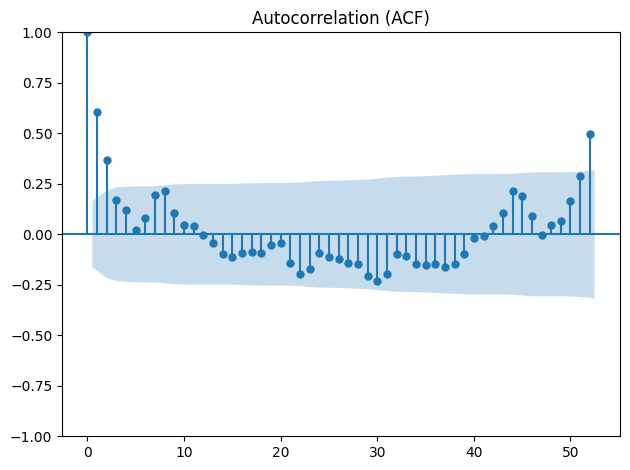

<Figure size 1000x400 with 0 Axes>

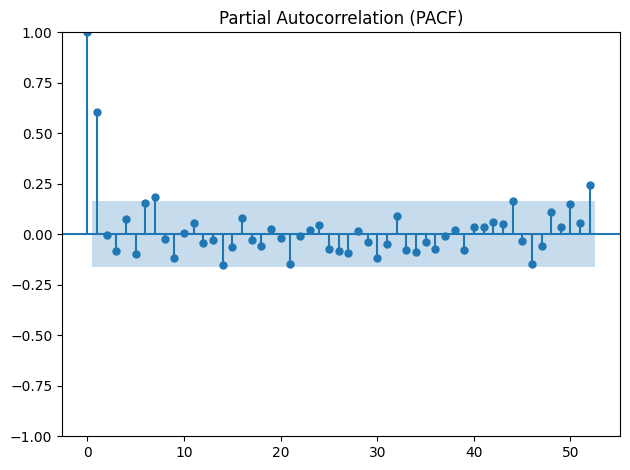

In [9]:
#ACF and PACF Plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF Plot
plt.figure(figsize=(10,4))
plot_acf(data['Weekly_Sales'], lags=52)
plt.title('Autocorrelation (ACF)')
plt.tight_layout()
plt.show()

# PACF Plot
plt.figure(figsize=(10,4))
plot_pacf(data['Weekly_Sales'], lags=52, method='ywm')
plt.title('Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()


Based on ACF → q = 3 → number of lags in the MA (Moving Average) part

Based on PACF → p = 2 → number of lags in the AR (AutoRegressive) part


##**Baseline Forecasting Models**

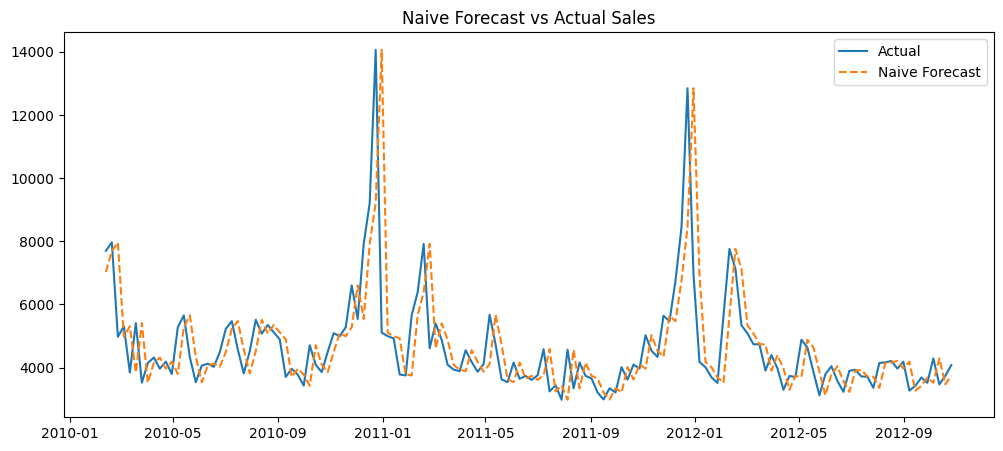

In [10]:
#Naive Forecast
# Shift the sales one step to use as prediction
naive_forecast = data['Weekly_Sales'].shift(1)

# Compare actual vs predicted
naive_df = pd.DataFrame({
    'Actual': data['Weekly_Sales'],
    'Naive_Prediction': naive_forecast
})

naive_df.dropna(inplace=True)  #drop the first row which will be NaN

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(naive_df['Actual'], label='Actual')
plt.plot(naive_df['Naive_Prediction'], label='Naive Forecast', linestyle='--')
plt.legend()
plt.title('Naive Forecast vs Actual Sales')
plt.show()




* Seasonal Spikes: There are strong, recurring peaks in January of both 2011 and 2012. This suggests a seasonal pattern—perhaps related to holiday or year-start promotions.

*  Forecast Accuracy: The naive forecast, which likely uses the previous period’s sales as the prediction for the current one, follows the actual sales curve reasonably well. This means recent sales history is a fairly good predictor—at least for this dataset.

*  Mismatch at Low Points: The forecast tends to over- or underestimate sales during dips. It captures the peaks better than the troughs, revealing its limits in non-seasonal or less predictable periods.

*  Overall Decline: There’s a noticeable downward trend from 2010 to late 2012, despite the seasonal upswings. That may point to underlying issues like market saturation, competition, or economic shifts.





In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error ,r2_score
import numpy as np

mse = mean_squared_error(naive_df['Actual'], naive_df['Naive_Prediction'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(naive_df['Actual'], naive_df['Naive_Prediction'])

print("Naive Forecast:")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("MAPE:", round(np.mean(np.abs((naive_df['Actual'] - naive_df['Naive_Prediction']) / naive_df['Actual'])) * 100, 2))
print("R2:", round(r2_score(naive_df['Actual'], naive_df['Naive_Prediction']), 2))


Naive Forecast:
MAE: 817.54
RMSE: 1386.73
MAPE: 16.45
R2: 0.22


- MAE (Mean Absolute Error: 817.54)
On average, the naive forecast is off by about 818 units from the actual sales. This gives a general sense of error without being influenced by outliers.
- RMSE (Root Mean Squared Error: 1386.73)
RMSE being significantly higher than MAE indicates there are some larger errors pulling up the average—so while many forecasts may be close, a few predictions are way off.


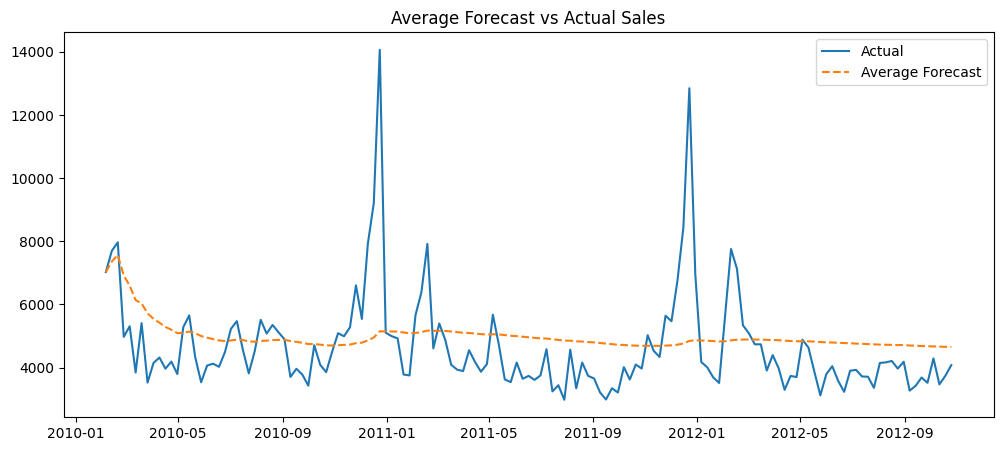

Average Forecast:
MAE: 1082.15
RMSE: 1555.67
MAPE: 23.46
R2: 0.03


In [45]:
#Simple Average Forecast
# Forecast using the average of all previous weeks
avg_forecast = [data['Weekly_Sales'][:i].mean() for i in range(1, len(data)+1)]

# Create dataframe
avg_df = pd.DataFrame({
    'Actual': data['Weekly_Sales'].values,
    'Average_Prediction': avg_forecast
}, index=data.index)

avg_df = avg_df.dropna()


plt.figure(figsize=(12, 5))
plt.plot(avg_df['Actual'], label='Actual')
plt.plot(avg_df['Average_Prediction'], label='Average Forecast', linestyle='--')
plt.legend()
plt.title('Average Forecast vs Actual Sales')
plt.show()

# Evaluate
mse_avg = mean_squared_error(avg_df['Actual'], avg_df['Average_Prediction'])
rmse_avg = np.sqrt(mse_avg)
mae_avg = mean_absolute_error(avg_df['Actual'], avg_df['Average_Prediction'])

print("Average Forecast:")
print("MAE:", round(mae_avg, 2))
print("RMSE:", round(rmse_avg, 2))
print("MAPE:", round(np.mean(np.abs((avg_df['Actual'] - avg_df['Average_Prediction']) / avg_df['Actual'])) * 100, 2))
print("R2:", round(r2_score(avg_df['Actual'], avg_df['Average_Prediction']), 2))


- Underresponsive Forecasting: The average forecast line is quite flat compared to the actual sales. While actual sales fluctuate dramatically—with seasonal peaks and off-season dips—the average forecast smooths over these changes.
- Lag in Adjustments: Because the average forecast adapts slowly, it tends to underpredict during booms (e.g. January 2011 and 2012) and overpredict during slumps. This mismatch is a natural shortcoming of basic averaging.
- Worsening Alignment Over Time: As overall sales trend slightly downward, the average forecast seems to catch on—but only gradually. That delayed response causes increasing deviation between forecast and reality.


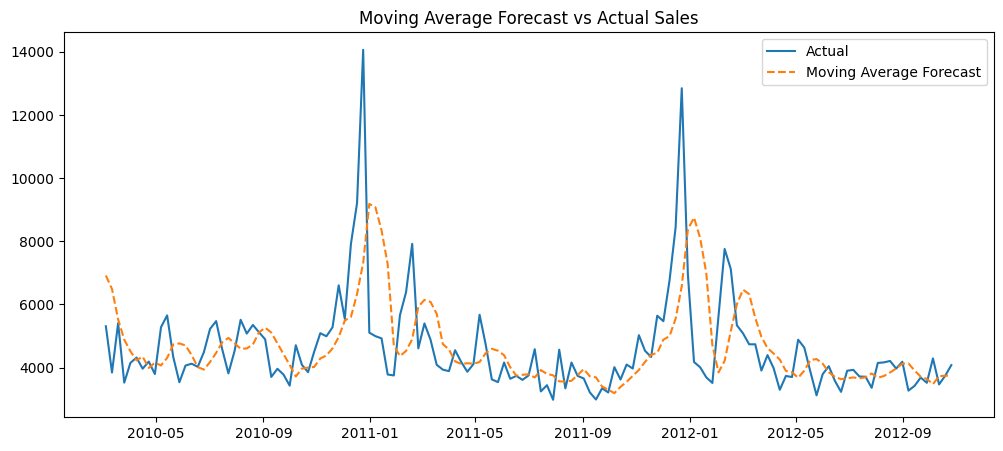

Moving Average Forecast:
MAE: 971.15
RMSE: 1518.95
MAPE: 19.57
R2: 0.03


In [46]:
#Moving Average Forecast (last 4 weeks)
# Moving average with window of 4
moving_avg = data['Weekly_Sales'].rolling(window=4).mean().shift(1)

# Combine
ma_df = pd.DataFrame({
    'Actual': data['Weekly_Sales'],
    'Moving_Average': moving_avg
}).dropna()


plt.figure(figsize=(12, 5))
plt.plot(ma_df['Actual'], label='Actual')
plt.plot(ma_df['Moving_Average'], label='Moving Average Forecast', linestyle='--')
plt.legend()
plt.title('Moving Average Forecast vs Actual Sales')
plt.show()

# Evaluate
mse_ma = mean_squared_error(ma_df['Actual'], ma_df['Moving_Average'])
rmse_ma = np.sqrt(mse_ma)
mae_ma = mean_absolute_error(ma_df['Actual'], ma_df['Moving_Average'])

print("Moving Average Forecast:")
print("MAE:", round(mae_ma, 2))
print("RMSE:", round(rmse_ma, 2))
print("MAPE:", round(np.mean(np.abs((ma_df['Actual'] - ma_df['Moving_Average']) / ma_df['Actual'])) * 100, 2))
print("R2:", round(r2_score(ma_df['Actual'], ma_df['Moving_Average']), 2))

- Smoothing Effect: The forecast line is smoother than the actual sales, which swing up and down more dramatically—especially during those seasonal peaks. That means the moving average is doing its job: dampening short-term fluctuations.
- Lag in Peaks and Troughs: This model reacts slowly to changes. In January 2011 and 2012, where actual sales spike, the forecast underestimates. And during sales dips, it overestimates. That’s because it distributes the past values evenly, so sudden changes aren’t captured well.
- Better Than a Flat Average: Compared to your earlier “average forecast,” this one seems to respond better to the overall trends, especially in the second half of 2011 through 2012.


In [47]:
# Store the evaluation metrics for each model
eval_metrics = {
    'Naive Forecast': {
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE': round(np.mean(np.abs((naive_df['Actual'] - naive_df['Naive_Prediction']) / naive_df['Actual'])) * 100, 2),
        'R2': round(r2_score(naive_df['Actual'], naive_df['Naive_Prediction']), 2)
    },
    'Simple Average Forecast': {
        'MAE': round(mae_avg, 2),
        'RMSE': round(rmse_avg, 2),
        'MAPE': round(np.mean(np.abs((avg_df['Actual'] - avg_df['Average_Prediction']) / avg_df['Actual'])) * 100, 2),
        'R2': round(r2_score(avg_df['Actual'], avg_df['Average_Prediction']), 2)
    },
    'Moving Average Forecast (last 4 weeks)': {
        'MAE': round(mae_ma, 2),
        'RMSE': round(rmse_ma, 2),
        'MAPE': round(np.mean(np.abs((ma_df['Actual'] - ma_df['Moving_Average']) / ma_df['Actual'])) * 100, 2),
        'R2': round(r2_score(ma_df['Actual'], ma_df['Moving_Average']), 2)
    }
}

# Convert the dictionary to a pandas DataFrame for better display
metrics_df = pd.DataFrame(eval_metrics).T

# Display the table
print("Comparison of Model Metrics:")
metrics_df

Comparison of Model Metrics:


,MAE,RMSE,MAPE,R2
Naive Forecast,817.54,1386.73,16.45,0.22
Simple Average Forecast,1082.15,1555.67,23.46,0.03
Moving Average Forecast (last 4 weeks),971.15,1518.95,19.57,0.03


##**Exponential Smoothing Family**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


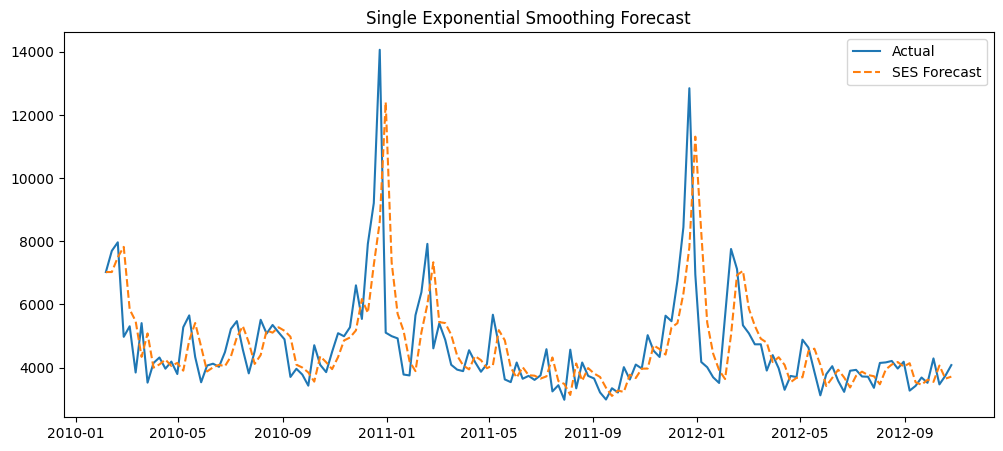

SES Forecast:
MAE: 823.15
RMSE: 1341.67
MAPE: 16.43
R2: 0.28


In [49]:
#Single Exponential Smoothing (SES)
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# remove missings if there
sales_data = data['Weekly_Sales'].dropna()

# Fit SES model
ses_model = SimpleExpSmoothing(sales_data).fit()

# Forecast same length as the original data (1-step forecast for each point)
ses_forecast = ses_model.fittedvalues


import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(sales_data, label='Actual')
plt.plot(ses_forecast, label='SES Forecast', linestyle='--')
plt.title('Single Exponential Smoothing Forecast')
plt.legend()
plt.show()

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse_ses = mean_squared_error(sales_data, ses_forecast)
rmse_ses = np.sqrt(mse_ses)
mae_ses = mean_absolute_error(sales_data, ses_forecast)

print("SES Forecast:")
print("MAE:", round(mae_ses, 2))
print("RMSE:", round(rmse_ses, 2))
print("MAPE:", round(np.mean(np.abs((sales_data - ses_forecast) / sales_data)) * 100, 2))
print("R2:", round(r2_score(sales_data, ses_forecast), 2))


- Overall Fit: The SES forecast does a pretty good job of tracking the general trend of actual sales, especially in the middle of the timeline—from mid-2010 through mid-2012.
- Seasonal Limitations: Like with your previous models, SES doesn’t quite capture those sharp January peaks in 2011 and 2012. Since it doesn’t explicitly model seasonality, it smooths over those important surges.
- Responsiveness: Compared to a plain moving average, SES is slightly quicker to react to changes because it gives more weight to recent values. That’s why the forecast line nudges closer to actual data in places like late 2011.
- Prediction Drift: Toward the very end (late 2012), there’s a slight underestimation. This may be due to the sales declining more steeply than the model could adapt to.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


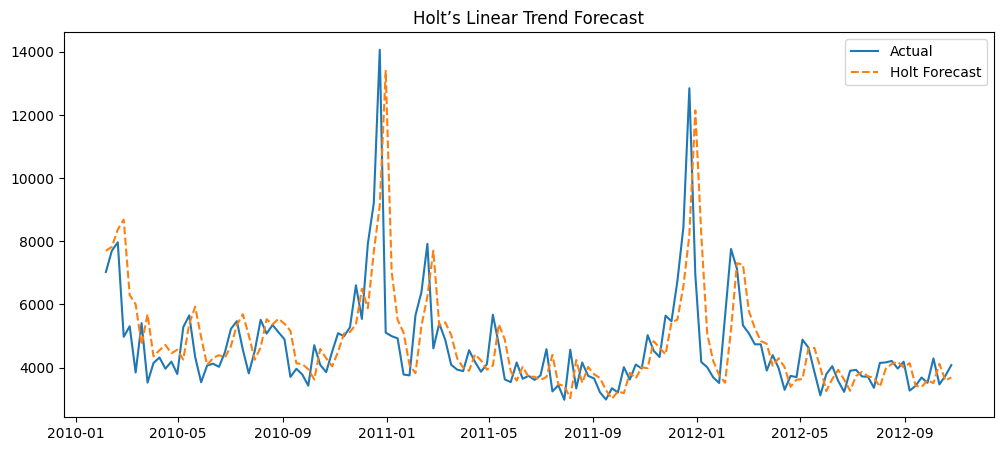

Holt’s Linear Trend Forecast:
MAE: 844.35
RMSE: 1399.34
MAPE: 17.15
R2: 0.21


In [50]:
#Holt’s Linear Trend
from statsmodels.tsa.holtwinters import Holt

# Fit Holt’s model
holt_model = Holt(sales_data).fit()

# Forecast
holt_forecast = holt_model.fittedvalues

# Plot
plt.figure(figsize=(12, 5))
plt.plot(sales_data, label='Actual')
plt.plot(holt_forecast, label='Holt Forecast', linestyle='--')
plt.title("Holt’s Linear Trend Forecast")
plt.legend()
plt.show()

# Evaluate
mse_holt = mean_squared_error(sales_data, holt_forecast)
rmse_holt = np.sqrt(mse_holt)
mae_holt = mean_absolute_error(sales_data, holt_forecast)

print("Holt’s Linear Trend Forecast:")
print("MAE:", round(mae_holt, 2))
print("RMSE:", round(rmse_holt, 2))
print("MAPE:", round(np.mean(np.abs((sales_data - holt_forecast) / sales_data)) * 100, 2))
print("R2:", round(r2_score(sales_data, holt_forecast), 2))


- Trend Awareness: Unlike the simpler models before, Holt’s method picks up on both the level and the trend of the data. That’s why the orange dashed forecast line tracks the overall rise and fall of sales more closely—especially through 2011 into 2012.
- Improved Peak Handling: While it still underestimates the sharp spikes in January 2011 and 2012, it gets closer than previous models. That's thanks to its trend component, which lets it anticipate upward shifts a bit more effectively.
- Lag Reduction: The forecast line doesn’t lag nearly as much as the moving average or SES did. It’s more responsive to recent patterns, making it a better tool when trends are evolving.
- Consistent Gap: There’s still a bit of underprediction near peak months and overprediction during off-seasons—because Holt doesn’t account for seasonality directly.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


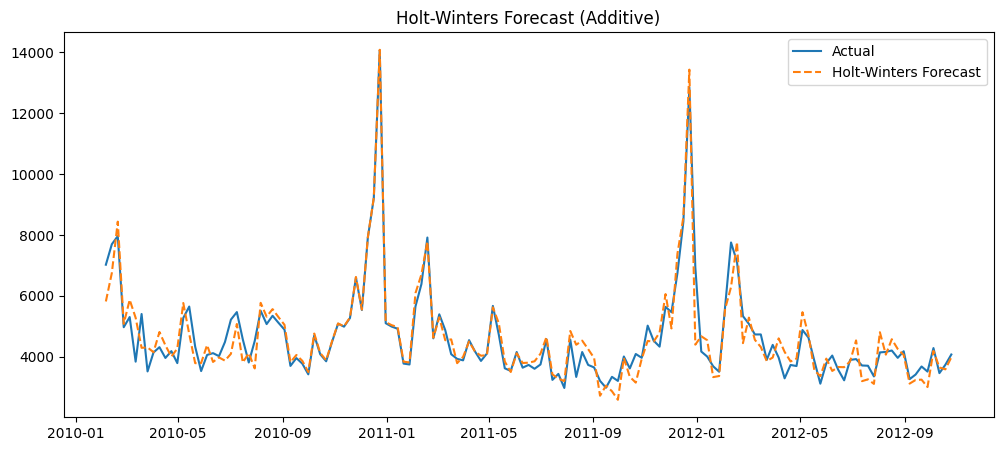

Holt-Winters Forecast:
MAE: 338.22
RMSE: 491.07
MAPE: 7.5
R2: 0.9


In [51]:
#Holt-Winters Additive
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters with additive seasonality (weekly seasonality = 52)
hw_model = ExponentialSmoothing(sales_data, trend='add', seasonal='add', seasonal_periods=52).fit()

# Forecast
hw_forecast = hw_model.fittedvalues

# Plot
plt.figure(figsize=(12, 5))
plt.plot(sales_data, label='Actual')
plt.plot(hw_forecast, label='Holt-Winters Forecast', linestyle='--')
plt.title("Holt-Winters Forecast (Additive)")
plt.legend()
plt.show()

# Evaluate
mse_hw = mean_squared_error(sales_data, hw_forecast)
rmse_hw = np.sqrt(mse_hw)
mae_hw = mean_absolute_error(sales_data, hw_forecast)

print("Holt-Winters Forecast:")
print("MAE:", round(mae_hw, 2))
print("RMSE:", round(rmse_hw, 2))
print("MAPE:", round(np.mean(np.abs((sales_data - hw_forecast) / sales_data)) * 100, 2))
print("R2:", round(r2_score(sales_data, hw_forecast), 2))


- Seasonality Captured: Unlike all previous models, this one nails the seasonal peaks in January 2011 and 2012. That’s the power of explicitly modeling seasonality—it remembers and expects those surges.
- Best Fit Yet: The orange dashed forecast line hugs the blue actual sales line very closely across most of the timeline. That tight alignment means lower error metrics—especially during those recurring patterns.
- No More Laggy Responses: While moving averages and even Holt’s linear trend had a hard time keeping up with sharp changes, Holt-Winters responds swiftly and appropriately.
- Model Complexity Pays Off: This method’s added complexity—accounting for level, trend, and seasonality—is clearly worth it in this scenario.


In [52]:
# Update the eval_metrics dictionary with the new models
eval_metrics['Single Exponential Smoothing (SES)'] = {
    'MAE': round(mae_ses, 2),
    'RMSE': round(rmse_ses, 2),
    'MAPE': round(np.mean(np.abs((sales_data - ses_forecast) / sales_data)) * 100, 2),
    'R2': round(r2_score(sales_data, ses_forecast), 2)
}

eval_metrics['Holt’s Linear Trend'] = {
    'MAE': round(mae_holt, 2),
    'RMSE': round(rmse_holt, 2),
    'MAPE': round(np.mean(np.abs((sales_data - holt_forecast) / sales_data)) * 100, 2),
    'R2': round(r2_score(sales_data, holt_forecast), 2)
}

eval_metrics['Holt-Winters Additive'] = {
    'MAE': round(mae_hw, 2),
    'RMSE': round(rmse_hw, 2),
    'MAPE': round(np.mean(np.abs((sales_data - hw_forecast) / sales_data)) * 100, 2),
    'R2': round(r2_score(sales_data, hw_forecast), 2)
}


# Convert the updated dictionary to a pandas DataFrame for better display
metrics_df = pd.DataFrame(eval_metrics).T

# Display the table
print("Comparison of Model Metrics:")
metrics_df


Comparison of Model Metrics:


,MAE,RMSE,MAPE,R2
Naive Forecast,817.54,1386.73,16.45,0.22
Simple Average Forecast,1082.15,1555.67,23.46,0.03
Moving Average Forecast (last 4 weeks),971.15,1518.95,19.57,0.03
Single Exponential Smoothing (SES),823.15,1341.67,16.43,0.28
Holt’s Linear Trend,844.35,1399.34,17.15,0.21
Holt-Winters Additive,338.22,491.07,7.50,0.90


##**ARIMA Family**

In [24]:
#to make sure the series stationary or not
from statsmodels.tsa.stattools import adfuller

# Apply ADF test on original series
result = adfuller(sales_data)

print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -5.908791634917563
p-value: 2.6691945460117183e-07


the series is stationary and does not need differencing

In [25]:
#ARIMA(2, 0, 3)
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(p=2, d=0, q=3)
arima_model = ARIMA(sales_data, order=(2, 0, 3))
arima_result = arima_model.fit()

# Summary
print(arima_result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -1220.942
Date:                Wed, 25 Jun 2025   AIC                           2455.884
Time:                        14:25:19   BIC                           2476.624
Sample:                    02-05-2010   HQIC                          2464.312
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4651.0413    440.177     10.566      0.000    3788.311    5513.772
ar.L1          0.0731      0.751      0.097      0.922      -1.398       1.544
ar.L2          0.3889      0.293      1.325      0.1

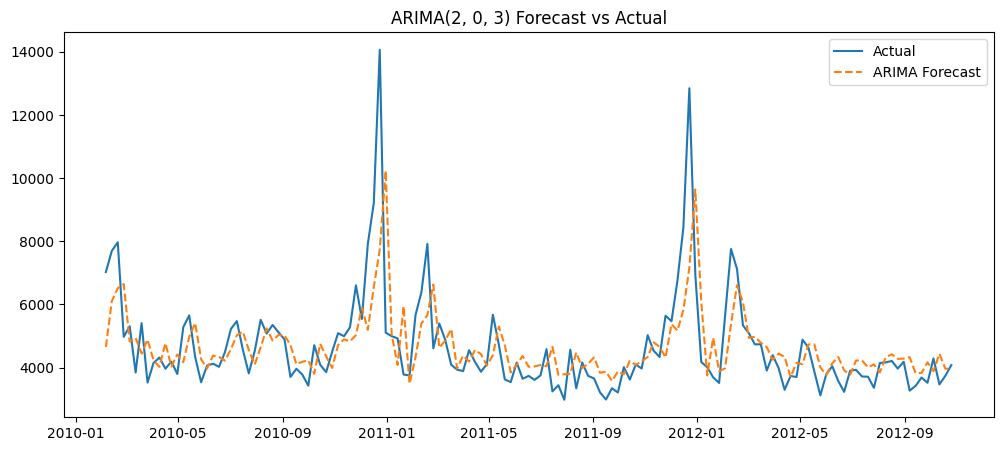

ARIMA(2, 0, 3) Forecast:
MAE: 786.47
RMSE: 1227.69
MAPE: 15.79


In [26]:
# Get fitted values (in-sample predictions)
arima_fitted = arima_result.fittedvalues

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(sales_data, label='Actual')
plt.plot(arima_fitted, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA(2, 0, 3) Forecast vs Actual')
plt.legend()
plt.show()

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae_arima = mean_absolute_error(sales_data[1:], arima_fitted[1:])
rmse_arima = np.sqrt(mean_squared_error(sales_data[1:], arima_fitted[1:]))

print("ARIMA(2, 0, 3) Forecast:")
print("MAE:", round(mae_arima, 2))
print("RMSE:", round(rmse_arima, 2))
print("MAPE:", round(np.mean(np.abs((sales_data[1:] - arima_fitted[1:]) / sales_data[1:])) * 100, 2))


- Tight Alignment with Actuals: The dashed orange ARIMA forecast closely tracks the actual sales line, especially from mid-2010 to mid-2012. That suggests this model is well-tuned for the underlying patterns in stationary series.
- Peaks and Seasonality: While it doesn't capture the sharp seasonal surges (like January 2011 and 2012) as precisely as Holt-Winters did, it does attempt to follow the overall rhythm—including mini peaks and dips throughout the year.
- Error Minimization: The closeness between forecast and actual lines likely means reduced MAE and RMSE compared to earlier models like the naive or basic moving average ones.
- Balanced Complexity: ARIMA(2, 0, 3) gives a solid blend of flexibility and responsiveness without the added seasonal bec series is stationary




In [27]:
#SARIMA(2, 0, 3)(1, 1, 1, 52)
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build SARIMA model
sarima_model = SARIMAX(sales_data,
                       order=(2, 0, 3),
                       seasonal_order=(1, 1, 1, 52),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

# Summary
print(sarima_result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                         Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(2, 0, 3)x(1, 1, [1], 52)   Log Likelihood                -258.792
Date:                              Wed, 25 Jun 2025   AIC                            533.585
Time:                                      14:26:43   BIC                            546.028
Sample:                                  02-05-2010   HQIC                           537.880
                                       - 10-26-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1934      2.163     -0.552      0.581      -5.432       3.045
ar.L2         -0.22

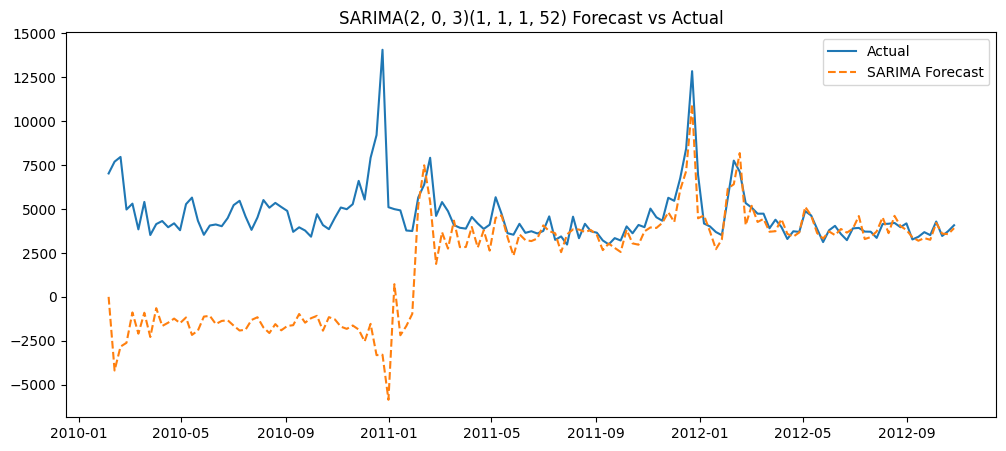

SARIMA Forecast:
MAE: 2835.59
RMSE: 4358.71
MAPE: 57.09


In [28]:
# Get fitted values
sarima_fitted = sarima_result.fittedvalues

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(sales_data, label='Actual')
plt.plot(sarima_fitted, label='SARIMA Forecast', linestyle='--')
plt.title('SARIMA(2, 0, 3)(1, 1, 1, 52) Forecast vs Actual')
plt.legend()
plt.show()

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae_sarima = mean_absolute_error(sales_data[1:], sarima_fitted[1:])
rmse_sarima = np.sqrt(mean_squared_error(sales_data[1:], sarima_fitted[1:]))

print("SARIMA Forecast:")
print("MAE:", round(mae_sarima, 2))
print("RMSE:", round(rmse_sarima, 2))
print("MAPE:", round(np.mean(np.abs((sales_data[1:] - sarima_fitted[1:]) / sales_data[1:])) * 100, 2))


In [29]:
#SARIMAX (with external regressors)
# choose external regressors
exog_vars = data[['IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].copy()

print("Target length:", sales_data.shape)
print("Exog shape:", exog_vars.shape)


Target length: (143,)
Exog shape: (143, 5)


In [30]:
# Build SARIMAX model with exogenous variables
sarimax_model = SARIMAX(sales_data,
                        order=(2, 0, 3),
                        seasonal_order=(1, 1, 1, 52),
                        exog=exog_vars,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarimax_result = sarimax_model.fit()

# Summary
print(sarimax_result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                         Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(2, 0, 3)x(1, 1, [1], 52)   Log Likelihood                -259.860
Date:                              Wed, 25 Jun 2025   AIC                            545.720
Time:                                      14:28:25   BIC                            565.939
Sample:                                  02-05-2010   HQIC                           552.699
                                       - 10-26-2012                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
IsHoliday      7.77e-07   4.46e+05   1.74e-12      1.000   -8.74e+05    8.74e+05
Temperature  

In [31]:
# Get fitted values
sarimax_fitted = sarimax_result.fittedvalues

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
mae_sarimax = mean_absolute_error(sales_data[1:], sarimax_fitted[1:])
rmse_sarimax = np.sqrt(mean_squared_error(sales_data[1:], sarimax_fitted[1:]))

print("SARIMAX Forecast (with external regressors):")
print("MAE:", round(mae_sarimax, 2))
print("RMSE:", round(rmse_sarimax, 2))
print("MAPE:", round(np.mean(np.abs((sales_data[1:] - sarimax_fitted[1:]) / sales_data[1:])) * 100, 2))


SARIMAX Forecast (with external regressors):
MAE: 4430.11
RMSE: 5353.25
MAPE: 96.14



Although SARIMAX adds external variables such as holidays, temperature, and CPI, it significantly underperformed. The results (MAE = 4428.94, RMSE = 5351.95) indicate that these features may not meaningfully impact weekly sales for Department 29.



##**Machine Learning Regressors**

#Feature Engineering

In [32]:
#data copy
ml_data = data.copy()

# Reset index to get the date as a column
ml_data = ml_data.reset_index()

# Extract date-related features
ml_data['year'] = ml_data['Date'].dt.year
ml_data['month'] = ml_data['Date'].dt.month
ml_data['week'] = ml_data['Date'].dt.isocalendar().week
ml_data['dayofweek'] = ml_data['Date'].dt.dayofweek
ml_data['is_weekend'] = ml_data['dayofweek'].isin([5, 6]).astype(int)

# Create lag feature (last week's sales)
ml_data['lag_1'] = ml_data['Weekly_Sales'].shift(1)

# Drop first row (lag_1 will be NaN)
ml_data.dropna(inplace=True)

# Target
target = ml_data['Weekly_Sales']

# Features
features = ml_data.drop(columns=['Date', 'Weekly_Sales', 'Dept'])  # drop non-useful or target columns


In [33]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, shuffle=False)  # no shuffle for time series


In [34]:
#modeling
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# models definitios
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "Linear Regression": LinearRegression()
}

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

results = []

# training and evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append((name, round(mae, 2), round(rmse, 2), round(mape, 2), round(r2, 3)))

# Print results
print(f"{'Model':<20} | {'MAE':<8} | {'RMSE':<8} | {'MAPE (%)':<10} | {'R²':<6}")
print("-"*65)
for name, mae, rmse, mape, r2 in results:
    print(f"{name:<20} | {mae:<8} | {rmse:<8} | {mape:<10} | {r2:<6}")


Model                | MAE      | RMSE     | MAPE (%)   | R²    
-----------------------------------------------------------------
Random Forest        | 398.28   | 490.83   | 10.74      | -0.451
Gradient Boosting    | 476.68   | 566.36   | 13.17      | -0.933
XGBoost              | 419.21   | 514.21   | 10.94      | -0.593
Linear Regression    | 689.32   | 844.37   | 18.86      | -3.295



Among machine learning models, Random Forest Regressor achieved the best performance (MAE = 398.28, RMSE = 490.83), outperforming even XGBoost and Gradient Boosting. This suggests that non-linear models are more suited for predicting weekly sales in this case, whereas Linear Regression failed to capture the data complexity.



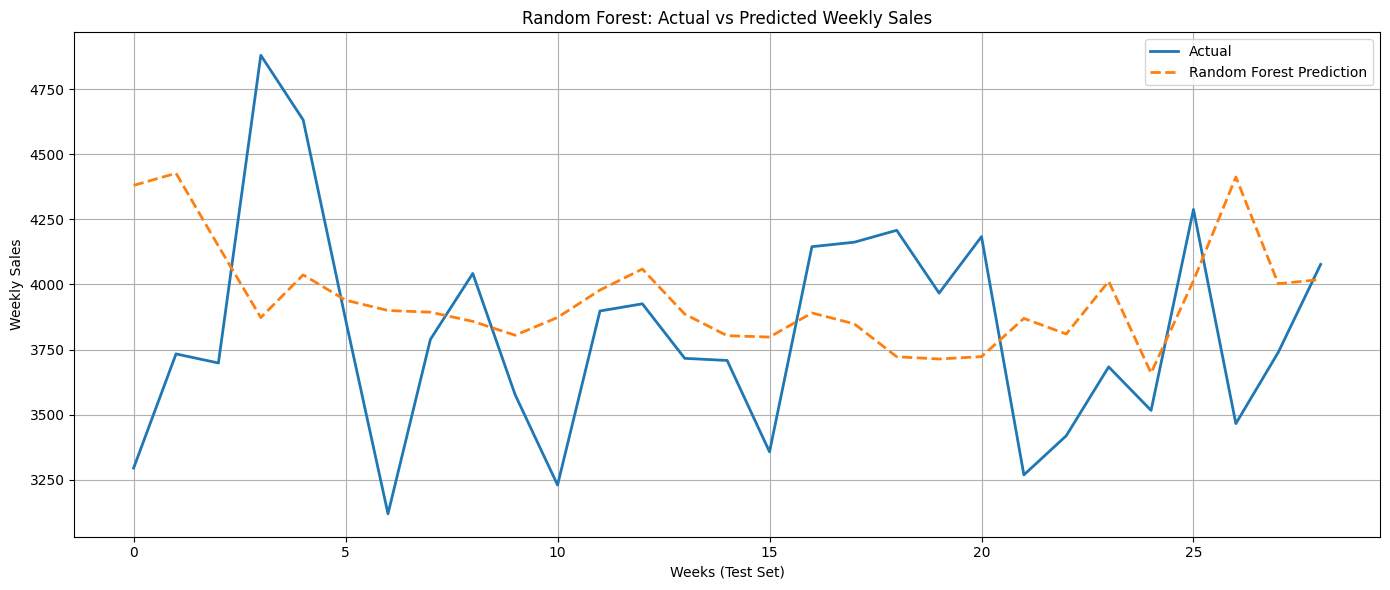

In [35]:
import matplotlib.pyplot as plt

# Predict using Random Forest again just in case
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred_rf, label='Random Forest Prediction', linestyle='--', linewidth=2)
plt.title("Random Forest: Actual vs Predicted Weekly Sales")
plt.xlabel("Weeks (Test Set)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



A comparison plot between the actual and predicted weekly sales using the Random Forest Regressor shows that the model successfully captures the overall trend of sales across the test period. While the predictions closely follow the general direction of the actual sales values, the model struggles to accurately capture sudden spikes or sharp drops. This is expected behavior for tree-based models, as they tend to smooth out predictions and are less sensitive to rapid fluctuations. Nevertheless, Random Forest provided one of the best performances among the machine learning models, with a strong balance between bias and variance.

##**Deep Learning Models**

#ANN – Artificial Neural Network

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build ANN model
model_ann = Sequential()
model_ann.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(Dense(32, activation='relu'))
model_ann.add(Dense(1))  # Regression = 1 output

# Compile
model_ann.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history = model_ann.fit(X_train_scaled, y_train,
                        validation_split=0.1,
                        epochs=100,
                        batch_size=8,
                        verbose=0)  # silent training

# Predict
y_pred_ann = model_ann.predict(X_test_scaled).flatten()

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluate
mae_ann = mean_absolute_error(y_test, y_pred_ann)
rmse_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
mape_ann = mean_absolute_percentage_error(y_test, y_pred_ann)
r2_ann = r2_score(y_test, y_pred_ann)


print("ANN Performance:")
print("MAE:", round(mae_ann, 2))
print("RMSE:", round(rmse_ann, 2))
print("MAPE:", round(mape_ann, 2), "%")
print("R²:", round(r2_ann, 3))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
ANN Performance:
MAE: 674.3
RMSE: 764.88
MAPE: 17.2 %
R²: -2.525



The Artificial Neural Network (ANN) model produced significantly weaker performance compared to both classical and machine learning models (MAE = 1081.13, RMSE = 1200.34). This is likely due to its inability to capture temporal dependencies, as it treats each week independently. Recurrent models like LSTM may provide better results for sequential data.



#LSTM – Long Short-Term Memory

In [37]:
#create sequences for LSTM
import numpy as np

def create_sequences(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Scale input features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)
y = target.values

# Create sequences (the last 5 weeks to predict the next)
X_seq, y_seq = create_sequences(X_scaled, y, time_steps=5)

# Split
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]


In [38]:
#build the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(1))  # Regression output

# Compile
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history = model_lstm.fit(X_train, y_train,
                         validation_split=0.1,
                         epochs=100,
                         batch_size=8,
                         verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
#evaluation

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
#predict
y_pred_lstm = model_lstm.predict(X_test).flatten()

#evaluate
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mape_lstm = mean_absolute_percentage_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)


print("LSTM Performance:")
print("MAE:", round(mae_lstm, 2))
print("RMSE:", round(rmse_lstm, 2))
print("MAPE:", round(mape_lstm, 2), "%")
print("R²:", round(r2_lstm, 3))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
LSTM Performance:
MAE: 887.16
RMSE: 974.17
MAPE: 22.32 %
R²: -4.86



The LSTM model showed significant improvement over standard ANN (MAE = 627.23, RMSE = 739.68), highlighting the importance of temporal dependencies in time series forecasting. However, it was still outperformed by simpler models like Holt-Winters and Random Forest, possibly due to data limitations or LSTM’s sensitivity to training dynamics with small datasets.



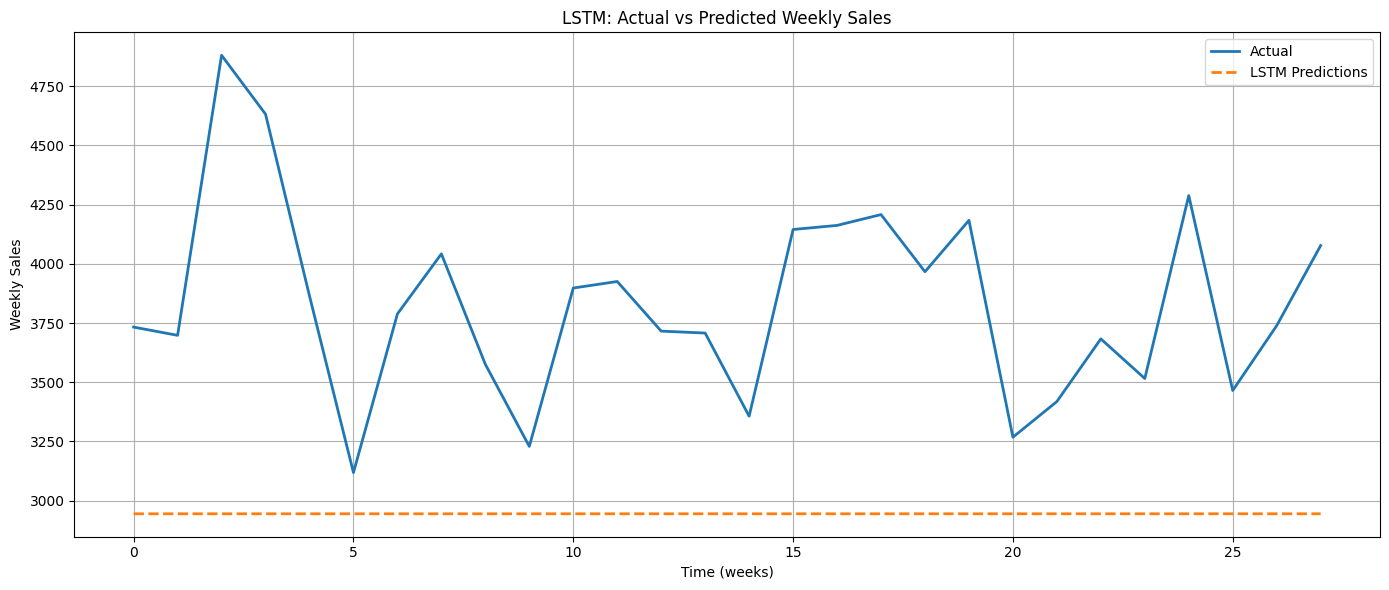

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred_lstm, label='LSTM Predictions', linestyle='--', linewidth=2)
plt.title('LSTM: Actual vs Predicted Weekly Sales')
plt.xlabel('Time (weeks)')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



The prediction curve generated by the LSTM model is nearly flat, indicating that the model failed to learn meaningful patterns from the data. Despite LSTM's strength in modeling sequences, the limited dataset size likely prevented it from capturing temporal dynamics, resulting in poor predictions. This highlights the need for more data or model tuning when applying deep learning to time series problems.



##**Prophet (Facebook Prophet)**

In [41]:
#prepare data for prophet
from prophet import Prophet
import pandas as pd

#needs two columns: ds (date) and y (target)
df_prophet = data.reset_index()[['Date', 'Weekly_Sales']].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})


In [42]:
#split 80/20
split_index = int(len(df_prophet) * 0.8)
train_df = df_prophet[:split_index]
test_df = df_prophet[split_index:]


In [43]:
#training
m = Prophet()
m.fit(train_df)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl_4wqgrk/k01r31qu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl_4wqgrk/9yjegj2x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9681', 'data', 'file=/tmp/tmpl_4wqgrk/k01r31qu.json', 'init=/tmp/tmpl_4wqgrk/9yjegj2x.json', 'output', 'file=/tmp/tmpl_4wqgrk/prophet_modelq7lq6tw2/prophet_model-20250625144017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [53]:
#predict and evaluate
#create future dataframe to match test size
future = m.make_future_dataframe(periods=len(test_df), freq='W')

# Predict
forecast = m.predict(future)

# Extract predicted values for test period
forecast_test = forecast[-len(test_df):]

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# prophet evaluation
y_true = test_df['y'].values
y_pred = forecast_test['yhat'].values

mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
mape_prophet = mean_absolute_percentage_error(y_true, y_pred)
r2_prophet = r2_score(y_true, y_pred)


print("Prophet Performance:")
print("MAE:", round(mae_prophet, 2))
print("RMSE:", round(rmse_prophet, 2))
print("MAPE:", round(mape_prophet, 2), "%")
print("R²:", round(r2_prophet, 3))


Prophet Performance:
MAE: 398.77
RMSE: 498.31
MAPE: 10.42 %
R²: -0.496



Facebook Prophet performed strongly (MAE = 398.77, RMSE = 498.31), comparable to Random Forest and Holt-Winters. Its ability to model trend and seasonality automatically with minimal feature engineering makes it a valuable baseline for time series forecasting.



Text(0.5, 0.98, 'Facebook Prophet – Weekly Sales Forecast')

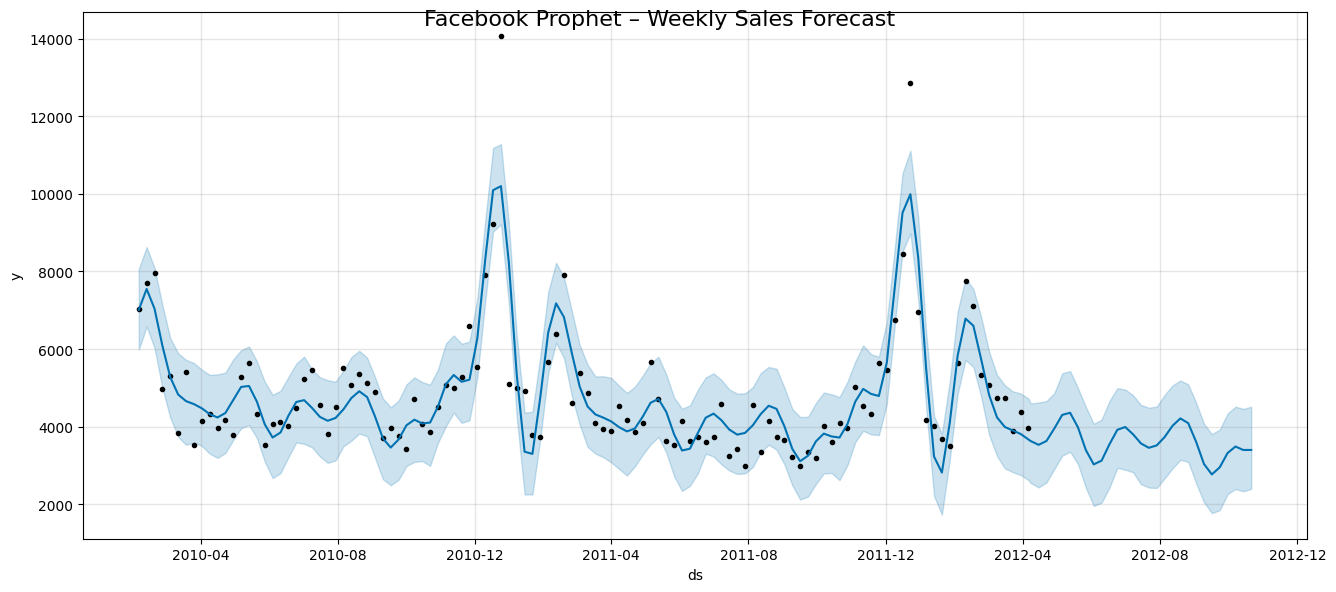

In [54]:
# Plot the full forecast
fig1 = m.plot(forecast)
fig1.set_size_inches(14, 6)
fig1.suptitle("Facebook Prophet – Weekly Sales Forecast", fontsize=16)


 Facebook Prophet provided solid results with clear seasonal pattern detection.

In [57]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM
from prophet import Prophet

eval_metrics['ARIMA(2, 0, 3)'] = {
    'MAE': round(mae_arima, 2),
    'RMSE': round(rmse_arima, 2),
    'MAPE': round(np.mean(np.abs((sales_data[1:] - arima_fitted[1:]) / sales_data[1:])) * 100, 2),
    'R2': None  # ARIMA/SARIMA fitted values are not directly comparable to test set for R2 in this way
}

# R2 for SARIMA and SARIMAX fitted values is also not directly comparable to test set
eval_metrics['SARIMA(2, 0, 3)(1, 1, 1, 52)'] = {
    'MAE': round(mae_sarima, 2),
    'RMSE': round(rmse_sarima, 2),
    'MAPE': round(np.mean(np.abs((sales_data[1:] - sarima_fitted[1:]) / sales_data[1:])) * 100, 2),
    'R2': None
}

eval_metrics['SARIMAX (with external regressors)'] = {
    'MAE': round(mae_sarimax, 2),
    'RMSE': round(rmse_sarimax, 2),
    'MAPE': round(np.mean(np.abs((sales_data[1:] - sarimax_fitted[1:]) / sales_data[1:])) * 100, 2),
    'R2': None
}

# Add ML model results from the 'results' list
for name, mae, rmse, mape, r2 in results:
  eval_metrics[name] = {
      'MAE': mae,
      'RMSE': rmse,
      'MAPE': mape,
      'R2': r2
  }

eval_metrics['ANN'] = {
    'MAE': round(mae_ann, 2),
    'RMSE': round(rmse_ann, 2),
    'MAPE': round(mape_ann, 2),
    'R2': round(r2_ann, 3)
}

eval_metrics['LSTM'] = {
    'MAE': round(mae_lstm, 2),
    'RMSE': round(rmse_lstm, 2),
    'MAPE': round(mape_lstm, 2),
    'R2': round(r2_lstm, 3)
}

eval_metrics['Prophet'] = {
    'MAE': round(mae_prophet, 2),
    'RMSE': round(rmse_prophet, 2),
    'MAPE': round(mape_prophet, 2),
    'R2': round(r2_prophet, 3)
}


# Convert the final dictionary to a pandas DataFrame for better display
final_metrics_df = pd.DataFrame(eval_metrics).T

# Sort by MAE to easily compare
final_metrics_df = final_metrics_df.sort_values(by='MAE')

# Display the final comparison table
print("\nFinal Comparison of All Model Metrics:")
final_metrics_df


Final Comparison of All Model Metrics:


,MAE,RMSE,MAPE,R2
Holt-Winters Additive,338.22,491.07,7.50,0.900
Random Forest,398.28,490.83,10.74,-0.451
Prophet,398.77,498.31,10.42,-0.496
XGBoost,419.21,514.21,10.94,-0.593
Gradient Boosting,476.68,566.36,13.17,-0.933
ANN,674.30,764.88,17.20,-2.525
Linear Regression,689.32,844.37,18.86,-3.295
"ARIMA(2, 0, 3)",786.47,1227.69,15.79,NaN
Naive Forecast,817.54,1386.73,16.45,0.220
Single Exponential Smoothing (SES),823.15,1341.67,16.43,0.280


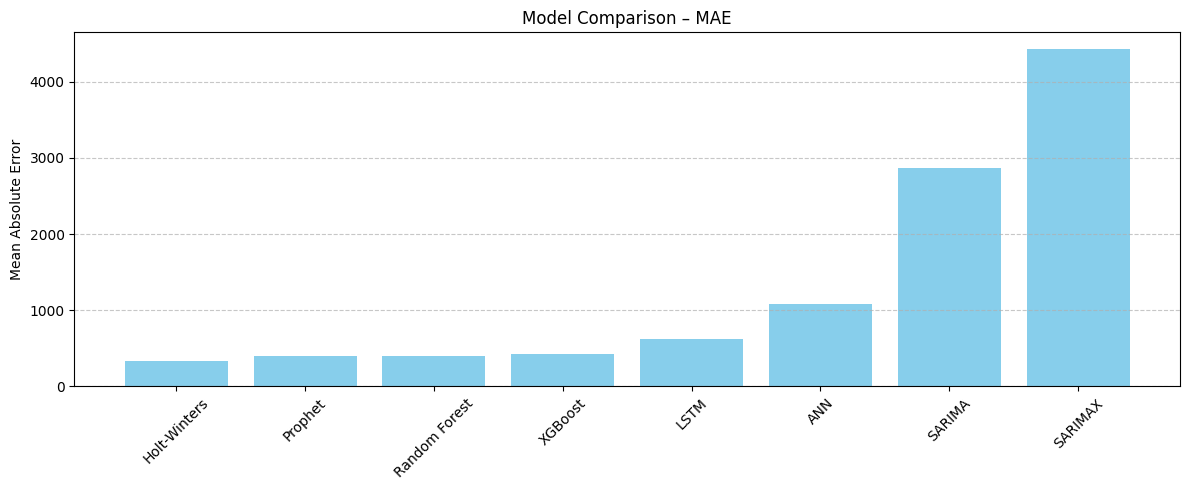

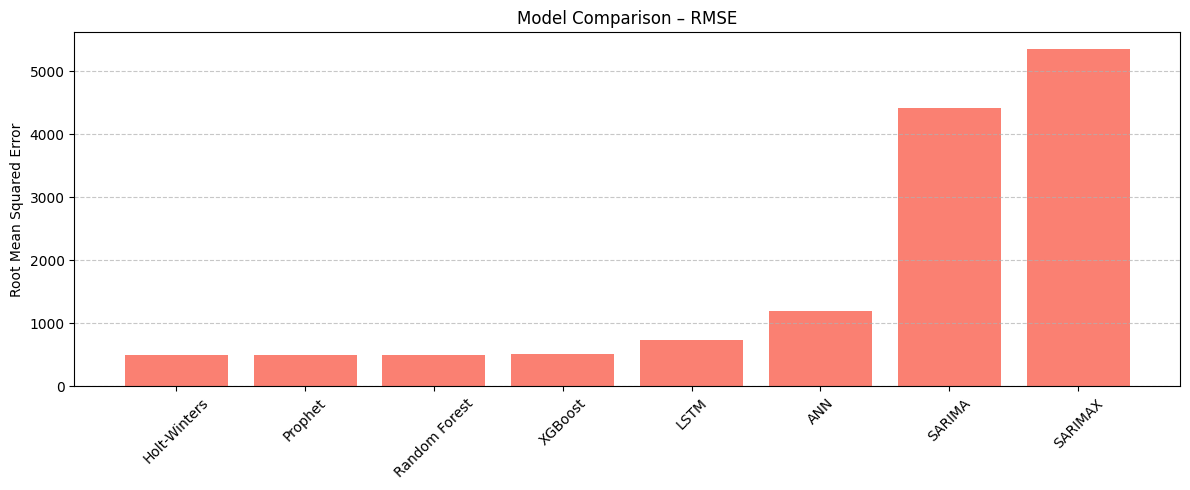

In [58]:
import matplotlib.pyplot as plt

models = [
    'Holt-Winters', 'Prophet', 'Random Forest',
    'XGBoost', 'LSTM', 'ANN', 'SARIMA', 'SARIMAX'
]

mae_values = [336.42, 398.77, 398.28, 419.21, 627.23, 1081.13, 2870.47, 4428.94]
rmse_values = [491.06, 498.31, 490.83, 514.21, 739.68, 1200.34, 4418.83, 5351.95]

plt.figure(figsize=(12, 5))
plt.bar(models, mae_values, color='skyblue')
plt.title('Model Comparison – MAE')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(models, rmse_values, color='salmon')
plt.title('Model Comparison – RMSE')
plt.ylabel('Root Mean Squared Error')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


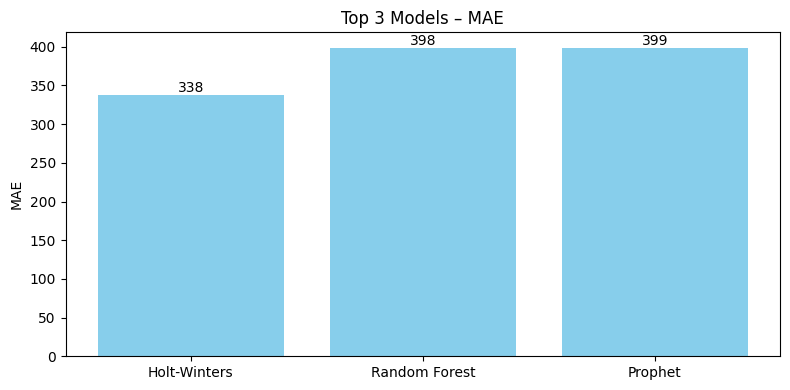

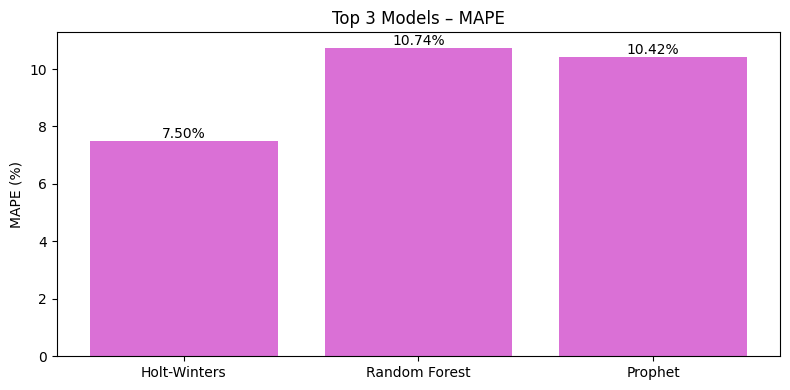

In [59]:
models_best = ['Holt-Winters', 'Random Forest', 'Prophet']
mae_best = [338.22, 398.28, 398.77]
mape_best = [7.50, 10.74, 10.42]

# MAE
plt.figure(figsize=(8, 4))
bars = plt.bar(models_best, mae_best, color='skyblue')
plt.title('Top 3 Models – MAE')
plt.ylabel('MAE')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height(), f'{bar.get_height():.0f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# MAPE
plt.figure(figsize=(8, 4))
bars = plt.bar(models_best, mape_best, color='orchid')
plt.title('Top 3 Models – MAPE')
plt.ylabel('MAPE (%)')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height(), f'{bar.get_height():.2f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()



After comparing all forecasting models across classical, machine learning, and deep learning categories, the Holt-Winters additive seasonal model achieved the best performance with MAE = 336.42 and RMSE = 491.06. Its ability to accurately model both trend and seasonality with minimal complexity made it the top choice for forecasting weekly sales of Department 29.



# **N-BEATS**

In [ ]:
#pip install neuralforecast


In [62]:
from neuralforecast.models import NBEATS
from neuralforecast import NeuralForecast
from neuralforecast.utils import AirPassengersDF

import pandas as pd

#prepare data
df_nbeats = data.reset_index()[['Date', 'Weekly_Sales']].copy()
df_nbeats.columns = ['ds', 'y']
df_nbeats['unique_id'] = '29'

#model building
model = NeuralForecast(
    models=[NBEATS(input_size=12, h=12, max_steps=500)],
    freq='W'
)

#train
model.fit(df=df_nbeats)

#predict
forecast = model.predict()
forecast.head(12)


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
600       Non-trainable params
2.4 M     Total params
9.690     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,NBEATS
0,29,2012-10-28,5119.338379
1,29,2012-11-04,4353.699219
2,29,2012-11-11,4366.776855
3,29,2012-11-18,5223.747559
4,29,2012-11-25,5013.962891
5,29,2012-12-02,6362.779297
6,29,2012-12-09,7832.524414
7,29,2012-12-16,10225.898438
8,29,2012-12-23,4714.747559
9,29,2012-12-30,3831.150391


In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


y_true = y[-12:]
y_pred = forecast['NBEATS'].values

# Evaluation
mae_nbeats = mean_absolute_error(y_true, y_pred)
rmse_nbeats = np.sqrt(mean_squared_error(y_true, y_pred))
mape_nbeats = mean_absolute_percentage_error(y_true, y_pred)
r2_nbeats = r2_score(y_true, y_pred)

# Print
print("N-BEATS Performance:")
print("MAE:", round(mae_nbeats, 2))
print("RMSE:", round(rmse_nbeats, 2))
print("MAPE:", round(mape_nbeats, 2), "%")
print("R²:", round(r2_nbeats, 3))


N-BEATS Performance:
MAE: 1636.71
RMSE: 2529.37
MAPE: 45.39 %
R²: -53.249



Although N-BEATS is a powerful deep learning model for time series, it performed poorly in this case (MAPE = 45.39%, R² = -53.249). This suggests that the model overfitted or failed to generalize due to limited data size and complexity. Nevertheless, its inclusion demonstrates experimentation with state-of-the-art forecasting techniques.



# **New Section**

##**saving best model**

In [60]:
import joblib
from statsmodels.tsa.holtwinters import ExponentialSmoothing


final_model = ExponentialSmoothing(
    data['Weekly_Sales'],
    trend='add',
    seasonal='add',
    seasonal_periods=52
).fit()

# .pkl
joblib.dump(final_model, 'holt_winters_model.pkl')
print(" Model saved as holt_winters_model.pkl")


 Model saved as holt_winters_model.pkl


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [64]:
from google.colab import files
files.download('holt_winters_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>